In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.HDFStore('data/data.h5','r')
parammat=data['parammat']
targ=data['targ']
data.close()

In [3]:
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2024-06-05 11:03:07.237822: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 11:03:07.285720: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 11:03:07.286583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 11:03:11.214417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
fflds=targ.columns.get_level_values(0)
fdates=targ.columns.get_level_values(1)
flds=targ.columns.get_level_values(0).unique()
dates=targ.columns.get_level_values(1).unique()
nflds=targ.shape[1]
nflds

20

In [5]:
dnn_model=keras.models.load_model('data/dnn_cicero.keras')

In [6]:
X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)

In [7]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)

1407/1407 [==============================] - 1s 562us/step


In [8]:
store = pd.HDFStore('data/obs.h5','r')
obs=store['obs']
obsunc=store['obsunc']
store.close()

In [9]:
np.where(targ.std()!=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),)

In [10]:
use=np.where(((np.isnan(obs)==False).to_numpy())&((targ.std()!=0).to_numpy()))

In [35]:
obsunc.loc['concentrations-CO2']=10
obsunc.loc['OHC700']=40
obsunc.loc['dT_glob']=0.3
obsunc.loc['RIB_glob']=0.35






In [36]:
obsunc

variable            year
dT_glob             1955     0.30
                    1975     0.30
                    1995     0.30
                    2008     0.30
                    2018     0.30
OHC700              1955    40.00
                    1975    40.00
                    1995    40.00
                    2008    40.00
                    2018    40.00
concentrations-CO2  1955    10.00
                    1975    10.00
                    1995    10.00
                    2008    10.00
                    2018    10.00
RIB_glob            1955     0.35
                    1975     0.35
                    1995     0.35
                    2008     0.35
                    2018     0.35
dtype: float64

In [37]:
def skillscore(targ,obs,obsunc,use):
  errm=(((obs.to_numpy()-targ)/obsunc.to_numpy())**2)
  out=-np.sum((errm[:,use[0]]),axis=1)
  return out

In [38]:
skl=skillscore(YTraining.to_numpy(),obs,obsunc,use)

In [39]:
bst=skl.argsort()[-1000:]

In [40]:
bst.shape

(1000,)

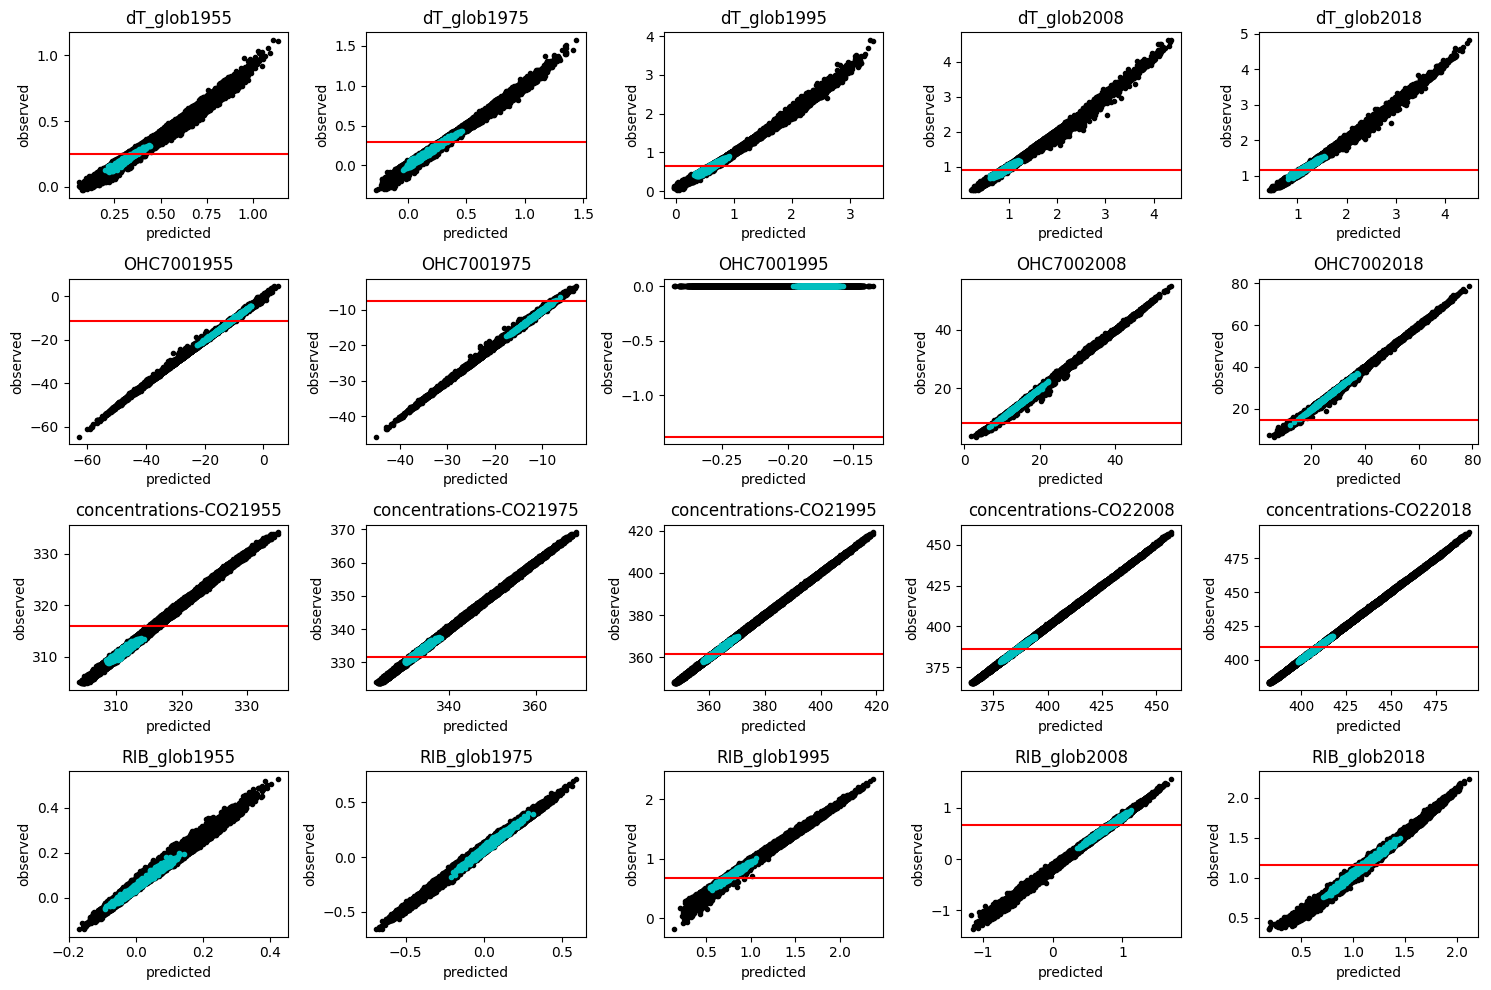

In [41]:
fig, ax = plt.subplots( len(flds), len(dates),figsize=(15, 10))

ax=ax.flatten()
for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'.k')
  ax[i].plot(pred_t[bst,i],Y_train.__array__()[bst,i],'.c')
  #ax[i].plot(pred[:,i],Y_dev[:,i],'r.')
  ax[i].set_title(fflds[i]+str(fdates[i]))
  ax[i].set_xlabel('predicted')
  ax[i].set_ylabel('observed')
  ax[i].axhline(obs[i],color='r')
plt.tight_layout()

In [42]:
pmin=XTraining.min()
pmax=XTraining.max()

In [46]:
def log_prob(p,obs,obsunc,use,pmin,pmax):
    ndim=p.shape[1]
    if type(p)!=pd.core.frame.DataFrame:
      p=pd.DataFrame(p)
    if len(p.shape)==1:
      p=p[np.newaxis,:]
    pred=dnn_model.predict(p,verbose = 0)
    out=skillscore(pred,obs,obsunc,use).T
    out[np.isnan(out)]=-5e5
    out[np.abs(out)>5e5]=-5e5
    inrange=(np.vstack([p.iloc[:,i].between(pmin.iloc[i],pmax.iloc[i]).to_numpy() for i in np.arange(ndim)]).sum(axis=0)!=ndim)*1e10
    out=out-inrange
    return out

In [47]:
predskl=log_prob(XTraining,obs,obsunc,use,pmin,pmax)

In [48]:
predskl

array([-26.42059444, -37.83264293,  -2.50901083, ..., -59.2782105 ,
        -8.31748119,  -4.25415792])

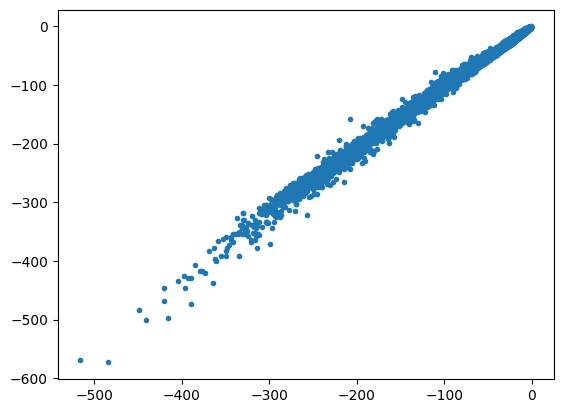

In [49]:
plt.plot(predskl,skl,'.')

In [50]:
import emcee


In [51]:
ndim=parammat.shape[1]


In [52]:


 nwalkers = len(bst)
ivar = 1. / np.random.rand(ndim)
p0 = X_train.__array__()[bst,:]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[obs,obsunc,use,pmin,pmax],vectorize=True)
sampler.run_mcmc(p0, 2000,progress=True)

100%|██████████| 2000/2000 [09:08<00:00,  3.64it/s]


State([[1.0475616e+01 5.0229537e-01 5.5379188e-01 ... 1.0572664e+02
  5.2228928e-01 9.9804595e-02]
 [7.8897047e+00 2.9012761e-01 2.5064194e-01 ... 8.2365280e+01
  2.9478022e-01 8.1090085e-02]
 [1.7732618e+01 3.3792201e-01 2.5569499e-01 ... 1.0345290e+02
  1.4794365e-01 8.7897092e-02]
 ...
 [1.1628510e+01 5.8645779e-01 2.1991567e-01 ... 9.8443207e+01
  1.8132972e-03 9.6128851e-02]
 [1.7520491e+01 4.8952144e-01 1.7236537e-01 ... 9.2525841e+01
  6.3293432e-03 8.7203152e-02]
 [1.8668856e+01 4.9944744e-01 5.3912061e-01 ... 8.8555138e+01
  4.5804548e-01 9.0873733e-02]], log_prob=[-3.70076153 -3.13400089 -2.63528588 -4.31049414 -2.56256621 -3.75827081
 -4.07699659 -2.04442636 -2.11150911 -1.77570351 -1.62472782 -1.98708663
 -3.57183314 -1.95526007 -1.85446477 -1.87867354 -2.22027732 -5.79414784
 -2.28662508 -2.76714614 -3.58088108 -6.32363471 -1.85851347 -2.63684861
 -1.81668868 -2.70043409 -4.30094026 -3.09433958 -2.89267398 -2.30901506
 -2.63292393 -1.39608649 -3.26777496 -1.52862407 -3.531

(array([ 2.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  1.,  1.,
         1.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  1.,  3.,  0.,  0.,  1.,
         0.,  1.,  1.,  1.,  2.,  0.,  1.,  1.,  1.,  3.,  3.,  5.,  3.,
         3.,  2.,  7.,  3.,  3.,  2.,  5.,  6.,  4.,  2., 10., 10.,  8.,
         6., 14., 14., 11., 14., 19., 13., 14., 18., 15., 14., 22., 15.,
        16., 13., 17., 15., 29., 25., 18., 17., 11., 24., 19., 22., 18.,
        34., 24., 23., 34., 27., 46., 21., 30., 33., 21., 20., 22., 13.,
        21., 20., 17., 19., 16.,  5.,  9.,  5.,  1.]),
 array([-6.76685593, -6.70747985, -6.64810377, -6.58872769, -6.52935161,
        -6.46997553, -6.41059945, -6.35122337, -6.29184729, -6.23247121,
        -6.17309513, -6.11371905, -6.05434297, -5.99496689, -5.93559081,
        -5.87621473, -5.81683865, -5.75746257, -5.69808649, -5.63871041,
        -5.57933433, -5.51995825, -5.46058217, -5.40120609, -5.34183001,
        -5.28245393, -5.22307785, -5.16370177, -5.10432569, -5.044949

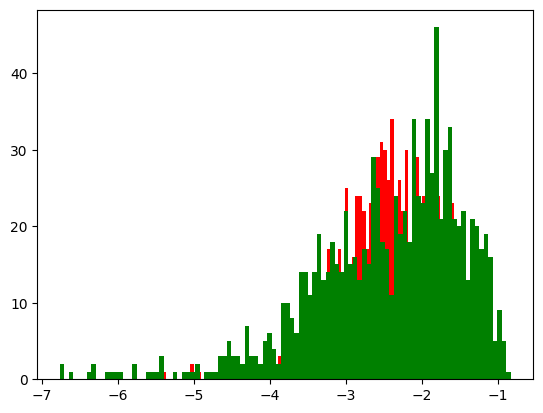

In [59]:
plt.hist(log_prob(p0,obs,obsunc,use,pmin,pmax),100,color='r')
plt.hist(log_prob(np.vstack(sampler.chain[:,-1:,:]),obs,obsunc,use,pmin,pmax),100,color='g')

In [54]:
opt=pd.DataFrame(sampler.chain[:,-1:,:].squeeze(),columns=parammat.columns)

In [55]:
opt.head()

,rlamdo,akapa,cpi,W,beto,lambda,mixed,qo3,qdirso2,qindso2,qbc,qoc,beta_f,mixed_carbon,qbmb,qh2o_ch4
0,10.475616,0.502295,0.553792,2.514032,0.013717,0.863986,59.383621,0.429927,-0.225164,-1.072242,0.116226,-0.081269,0.299075,105.726639,0.522289,0.099805
1,7.889705,0.290128,0.250642,0.870145,1.446353,0.893113,113.520798,0.432880,-0.481915,-0.802020,0.199123,-0.066516,0.409709,82.365280,0.294780,0.081090
2,17.732618,0.337922,0.255695,1.251476,6.316676,0.741933,36.095787,0.411850,-0.205811,-1.417092,0.166565,-0.069327,0.226827,103.452904,0.147944,0.087897
3,14.920824,0.414036,0.495488,1.495864,0.022815,0.835873,106.709068,0.517617,-0.211166,-1.131205,0.191776,-0.063977,0.174872,115.631096,0.562069,0.095075
4,19.125523,0.277932,0.487439,2.345146,3.487210,0.613512,116.704987,0.439732,-0.262827,-0.775322,0.169647,-0.094645,0.256386,115.203690,0.281968,0.084501


In [56]:
store = pd.HDFStore('data/optparam.h5')
store['opt'] = opt
store.close()